# Ejercicio 4

Real filtro de partículas (parte de pronóstico). Se toma un instante inicial y se rescata la distribución de probabilidad calculada de forma teórica para el proceso, se samplea un conjunto de partículas y se propagan por el modelo para rescatar la pdf.

Primero, se simula el proceso por MC y luego se rescata la pdf con la parte de pronóstico del filtro de partículas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

In [2]:
# creacion de histogramas
def histograma(hist, bins, alpha=1, color=None, label=''):
    X = np.linspace(0, len(hist), num=bins + 1)
    result = np.zeros(X.shape)
    j = 0
    l = 0
    for i, h in enumerate(hist):
        if i > X[j]:
            result[j] = np.sum(hist[l:i])
            l = i
            j += 1
    plt.bar(X, result, width=len(hist)/bins + 1, alpha=alpha, color=color, label=label)
    return [X, result]
            

Elapsed time: 1.4374s
50000
1.0 50000


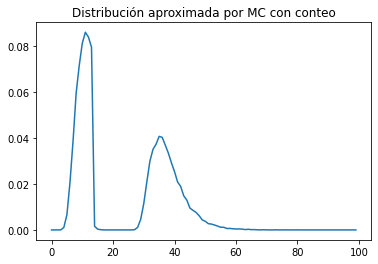

In [3]:
# primero se crea el proceso y se samplea con MC la ground truth

x_0 = 1
N = 100

proceso = np.zeros((N,))
proceso[0] = x_0
a1 = 1.01
b1 = 0.75
sigma = 0.8
np.random.seed(32)
u = 8
K = 0.5

# definicion de las iteraciones de MC
M = 50000
PROCESOS = np.zeros((N,M))
PROCESOS[0, :] = x_0
np.random.seed(42)

cuentas = np.zeros((M,))
histogram_MC = np.zeros((N,))

I, J = [13, 26]

# media y varianza analiticas
E = np.zeros((N,))
Var = np.zeros((N,))

E[0] = proceso[0]

start = time.time()

for i in range(I):
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))
    
    anterior = np.sum(cuentas != 0)
    checkeo = PROCESOS[i, :] > u
    for j in range(M):
        if cuentas[j] == 0.0 and checkeo[j]: cuentas[j] = i
        
    histogram_MC[i] = (np.sum(cuentas != 0) - anterior) / M
    
    # media y varianza
    E[i + 1] = K + a1 * E[i]
    Var[i + 1] = a1 ** 2 * Var[i] + sigma**2
    

for i in range(I, J):
    proceso[i + 1] = K + a1 * b1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * b1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))

    anterior = np.sum(cuentas != 0)
    checkeo = PROCESOS[i, :] > u
    for j in range(M):
        if cuentas[j] == 0.0 and checkeo[j]: cuentas[j] = i
        
    histogram_MC[i] = (np.sum(cuentas != 0) - anterior) / M
    
    # media y varianza
    E[i + 1] = K + a1 * b1 * E[i]
    Var[i + 1] = a1 ** 2 * b1 ** 2 * Var[i] + sigma**2

for i in range(J, int((N-1))):
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))
    
    anterior = np.sum(cuentas != 0)
    checkeo = PROCESOS[i, :] > u
    for j in range(M):
        if cuentas[j] == 0.0 and checkeo[j]: cuentas[j] = i
        
    histogram_MC[i] = (np.sum(cuentas != 0) - anterior) / M
    
    # media y varianza
    E[i + 1] = K + a1 * E[i]
    Var[i + 1] = a1 ** 2 * Var[i] + sigma**2
end = time.time()
print('Elapsed time: {:.4f}s'.format(end - start))

print(np.sum(cuentas != 0))

# plt.plot(PROCESOS, color='k', alpha=0.1)
# plt.plot(proceso, color='r', lw=3)
# plt.plot(E, color='g', lw=5)
# plt.plot(E - np.sqrt(Var), color='g', lw=5, alpha=0.5)
# plt.plot(E + np.sqrt(Var), color='g', lw=5, alpha=0.5)
# plt.hlines(u,0,N)
# plt.ylim(top=u*2.4, bottom=-u)
# plt.title('Simulaciones con Monte Carlo del proceso $a_1={}, b_1={}, k={}, \sigma={}$'.format(a1,b1,K,sigma))
# plt.show()

print(np.sum(histogram_MC), M)
plt.plot(histogram_MC)
plt.title('Distribución aproximada por MC con conteo')
plt.show()

A continuación, se sacará la parte del filtrado

Elapsed time: 0.0251s
1.0 400


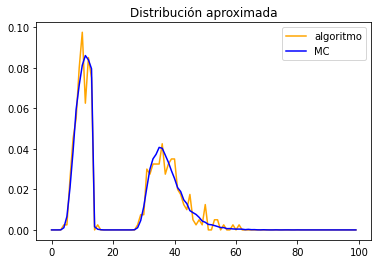

In [8]:
# se toma el instante inicial
k = 0
m = 400 # cantidad de particulasnumpy 
particulas = np.zeros((N,m))
particulas[k,:] = np.random.normal(E[k], np.sqrt(Var[k]), size=m)
# particulas[k,:] = E[k]

cuentas2 = np.zeros((m,))
histogram_filtro = np.zeros((N,))
anterior = 0
total = 0
indices_bajo_umbral = np.arange(0,N)

# paso de propagacion de las particulas

start = time.time()
for i in range(k, I):    
    anterior = total
    for j, p in enumerate(particulas[i, :]):
        if cuentas2[j] == 0.0 and p > u:
            total += 1
            cuentas2[j] = i
            
    histogram_filtro[i] = (total - anterior) / (m)
    
    particulas[i + 1, :] = K + a1 * particulas[i,:] + np.random.normal(0, sigma, size=m)

for i in range(I, J):
    anterior = total
    for j, p in enumerate(particulas[i, :]):
        if cuentas2[j] == 0.0 and p > u:
            total += 1
            cuentas2[j] = i
            
    histogram_filtro[i] = (total - anterior) / (m)
    
    particulas[i + 1, :] = K + a1 * b1 * particulas[i,:] + np.random.normal(0, sigma, size=m)

for i in range(J, int((N-1))):    
    anterior = total
    for j, p in enumerate(particulas[i, :]):
        if cuentas2[j] == 0.0 and p > u:
            total += 1
            cuentas2[j] = i
            
    histogram_filtro[i] = (total - anterior) / (m)
    
    particulas[i + 1, :] = K + a1 * particulas[i,:] + np.random.normal(0, sigma, size=m)
    
end = time.time()
print('Elapsed time: {:.4f}s'.format(end - start))

print(np.sum(histogram_filtro), m)
plt.plot(histogram_filtro, label='algoritmo', color='orange')
plt.plot(histogram_MC, label='MC', color='b')
plt.title('Distribución aproximada')
plt.legend()
plt.show()


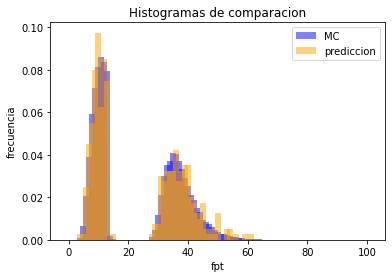

In [9]:
x, h = histograma(histogram_MC, bins=len(histogram_MC), alpha=0.5, color='b', label='MC')
x, h = histograma(histogram_filtro, bins=len(histogram_filtro), alpha=0.5, color='orange', label='prediccion')
# plt.plot(histogram_filtro, label='prediccion', color='orange')
# plt.plot(histogram_MC, label='MC', color='b')
plt.legend()
plt.xlabel('fpt')
plt.ylabel('frecuencia')
plt.title('Histogramas de comparacion')
plt.show()


[0.23001377 0.26000175 0.10575192 0.37361911 0.3618841  0.4086277
 0.38855349 0.47550577 0.27315788 0.49257521] 3.3696906906103994
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 10.0
Elapsed time: 0.0118s
3.9087480497813276 10


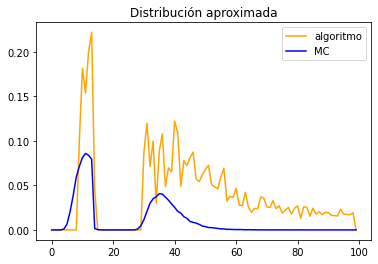

In [6]:
# se toma el instante inicial
k = 1
m = 10 # cantidad de particulasnumpy 
particulas = np.zeros((N,m))
particulas[k,:] = np.random.normal(E[k], np.sqrt(Var[k]), size=m)
# particulas[k,:] = E[k]

histogram_filtro = np.zeros((N,))
promedio_particulas = np.zeros((N,))
anterior = 0
total = 0
indices_bajo_umbral = np.arange(0,N)

peso_particula = np.ones((N,m))

peso_particula[k,:] = norm.pdf(particulas[k,:], loc=E[k], scale=np.sqrt(Var[k]))
# paso de propagacion de las particulas

start = time.time()
for i in range(k, I):
    
    print(peso_particula[i, :], np.sum(peso_particula[i, :]))
    anterior = total
    p_bajo_u = 0
    bajo_u = 0
    idx_sobre_u = []
    for j, p in enumerate(particulas[i, :]):
        
        if p < u:
            p_bajo_u += p
            bajo_u += 1
        else:
            total += 1
#             l = u + 1
#             while(l > u):
#                 l = np.random.normal(E[i], np.sqrt(Var[i]))
#             l = np.random.uniform(np.min(particulas[i,:]), u)
            particulas[i,j] = u
            idx_sobre_u.append(j)
            
#     print(particulas[i, :])
#     particulas[i, np.array(idx_sobre_u, dtype=int)] = p_bajo_u / bajo_u

    particulas[i + 1, :] = K + a1 * particulas[i,:] + np.random.normal(0, sigma, size=m)
    histogram_filtro[i] = (total - anterior) / (m + anterior)
    
    promedio_particulas[i] = np.mean(particulas[i,:])
    
#     print(total - anterior, histogram_filtro[i], np.sum(particulas[i, :] < u))

for i in range(I, J):
    
    anterior = total
    p_bajo_u = 0
    bajo_u = 0
    idx_sobre_u = []
    for j, p in enumerate(particulas[i, :]):
        
        if p < u:
            p_bajo_u += p
            bajo_u += 1
        else:
            total += 1
#             l = u + 1
#             while(l > u):
#                 l = np.random.normal(E[i], np.sqrt(Var[i]))
#             l = np.random.uniform(np.min(particulas[i,:]), u)
            particulas[i,j] = u
            idx_sobre_u.append(j)
            
#     print(particulas[i, :])
#     particulas[i, np.array(idx_sobre_u, dtype=int)] = p_bajo_u / bajo_u

    particulas[i + 1, :] = K + a1 * b1 * particulas[i,:] + np.random.normal(0, sigma, size=m)
    histogram_filtro[i] = (total - anterior) / (m + anterior)
    
    promedio_particulas[i] = np.mean(particulas[i,:])
    
#     print(total - anterior, histogram_filtro[i], np.sum(particulas[i, :] < u))
    

for i in range(J, int((N-1))):
    
    anterior = total
    p_bajo_u = 0
    bajo_u = 0
    idx_sobre_u = []
    for j, p in enumerate(particulas[i, :]):
        
        if p < u:
            p_bajo_u += p
            bajo_u += 1
        else:
            total += 1
#             l = u + 1
#             while(l > u):
#                 l = np.random.normal(E[i], np.sqrt(Var[i]))
#             l = np.random.uniform(np.min(particulas[i,:]), u)
            particulas[i,j] = u
            idx_sobre_u.append(j)
            
#     print(particulas[i, :])
#     particulas[i, np.array(idx_sobre_u, dtype=int)] = p_bajo_u / bajo_u

    particulas[i + 1, :] = K + a1 * particulas[i,:] + np.random.normal(0, sigma, size=m)
    histogram_filtro[i] = (total - anterior) / (m + anterior)
    
    promedio_particulas[i] = np.mean(particulas[i,:])
    
#     print(total - anterior, histogram_filtro[i], np.sum(particulas[i, :] < u))
    
    
end = time.time()
print('Elapsed time: {:.4f}s'.format(end - start))


# plt.plot(particulas, color='k', alpha=0.1)
# plt.plot(proceso, color='r', lw=3)
# plt.plot(E, color='g', lw=5)
# plt.plot(E - np.sqrt(Var), color='g', lw=5, alpha=0.5)
# plt.plot(E + np.sqrt(Var), color='g', lw=5, alpha=0.5)
# plt.plot(promedio_particulas, color='y', lw = 5, alpha=0.5)
# # plt.hlines(u,0,N)
# plt.ylim(top=u*2.4, bottom=-u)
# plt.title('Simulaciones con Monte Carlo del proceso $a_1={}, b_1={}, k={}, \sigma={}$'.format(a1,b1,K,sigma))
# plt.show()

print(np.sum(histogram_filtro), m)
plt.plot(histogram_filtro, label='algoritmo', color='orange')
plt.plot(histogram_MC, label='MC', color='b')
plt.title('Distribución aproximada')
plt.legend()
plt.show()


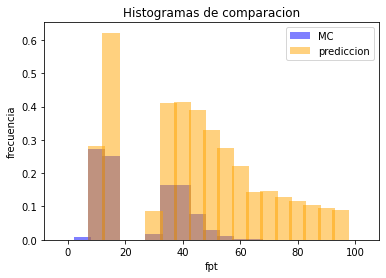

In [7]:
x, h = histograma(histogram_MC, bins=20, alpha=0.5, color='b', label='MC')
x, h = histograma(histogram_filtro, bins=20, alpha=0.5, color='orange', label='prediccion')
# plt.plot(histogram_filtro, label='prediccion', color='orange')
# plt.plot(histogram_MC, label='MC', color='b')
plt.legend()
plt.xlabel('fpt')
plt.ylabel('frecuencia')
plt.title('Histogramas de comparacion')
plt.show()
